https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

In [1]:
# import libs and config stuff
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
#%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl



import numpy as np
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten

<ipython-input-1-e56fe135fc6e>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 32.2 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


<Figure size 640x480 with 0 Axes>

In [2]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/USP/TCC/experiments/saved_models/ViT/mark1"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)



# LOAD DATASET
img_size = 72
train_data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((img_size,img_size),scale=(0.8,1.0),ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

test_data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

train_flowers_set = datasets.ImageFolder(root='/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train',
                                           transform=train_data_transform)

val_flowers_set = datasets.ImageFolder(root='/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/val',
                                           transform=test_data_transform)

test_flowers_set = datasets.ImageFolder(root='/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/test',
                                           transform=test_data_transform)


train_loader = torch.utils.data.DataLoader(train_flowers_set,
                                             batch_size=280, shuffle=True,
                                             num_workers=1)

val_loader = torch.utils.data.DataLoader(val_flowers_set,
                                             batch_size=35, shuffle=False,
                                             num_workers=1)

test_loader = torch.utils.data.DataLoader(test_flowers_set,
                                             batch_size=35, shuffle=False,
                                             num_workers=1)


INFO:lightning_fabric.utilities.seed:Global seed set to 42


Device: cuda:0


In [3]:
for data in test_loader:
  (x_test, y_test) = data
for data in train_loader:
  (x_train, y_train) = data

print(f"x_train shape: {x_test.shape} - y_train shape: {y_test.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

y_test = y_test.reshape((35,1))
y_test = y_test.numpy()
x_test = np.moveaxis(x_test.numpy(), 1, 3)
x_test = np.moveaxis(x_test, 1, 2)

y_train = y_train.reshape((280,1))
y_train = y_train.numpy()
x_train = np.moveaxis(x_train.numpy(), 1, 3)
x_train = np.moveaxis(x_train, 1, 2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

n_classes = 7
input_shape = (72, 72, 3)


x_train shape: torch.Size([35, 3, 72, 72]) - y_train shape: torch.Size([35])
x_test shape: torch.Size([35, 3, 72, 72]) - y_test shape: torch.Size([35])
x_train shape: (280, 72, 72, 3) - y_train shape: (280, 1)
x_test shape: (35, 72, 72, 3) - y_test shape: (35, 1)


In [5]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [11]:
optim_1 = Adam(learning_rate=0.001)

n_steps = 280#traingen.samples // BATCH_SIZE
n_val_steps = 35#validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_test, y_test),
        # validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


model = create_model(input_shape, n_classes, Adam(learning_rate=0.001), fine_tune=0)
history = run_experiment(model)

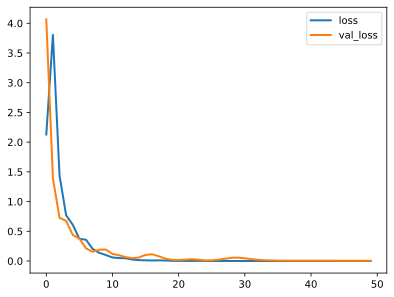

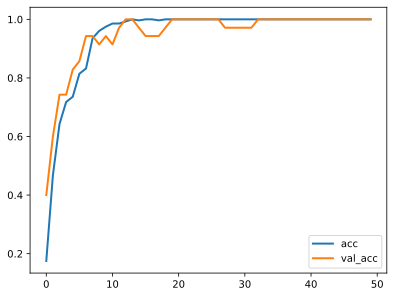

In [25]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [26]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 72, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 36, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 36, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0   